In [41]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt

from tensorflow import keras
from keras.layers import Dense, Dropout

# Load the data

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

X_train_file = 'X_train_scaled.csv' #X_train_scaled
y_train_file = 'y_train.csv'

X_test_file = 'X_test_scaled.csv' #X_test_scaled
y_test_file = 'y_test.csv'

_inputs = 0
_output = 1
_rows = 0
_batch = 0
_epoch = 0

In [43]:
def plot_loss(h):
    plt.plot(h.history['loss']) 
    plt.plot(h.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show()

In [44]:
def plot_precision(h, p, v_p):
    plt.plot(h.history[p])
    plt.plot(h.history[v_p])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [45]:
X_train = pd.read_csv('../data/processed/' + X_train_file)
z_train = pd.read_csv('../data/processed/' + y_train_file)

X_test = pd.read_csv('../data/processed/' + X_test_file)
z_test = pd.read_csv('../data/processed/' + y_test_file)

In [46]:
print(X_train.shape)
print(z_train.shape)
print(X_test.shape)
print(z_test.shape)

X_train.drop(columns=['Unnamed: 0'], axis =1, inplace = True)
X_test.drop(columns=['Unnamed: 0'], axis =1, inplace = True)

y_train = z_train['Label']
y_test = z_test['Label']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(224376, 32)
(224376, 2)
(75000, 32)
(75000, 2)
(224376, 31)
(224376,)
(75000, 31)
(75000,)


In [47]:
_inputs =  len(X_train. columns) 
_rows = len(X_train. index)

_epoch = 100
_batch = round(_rows/_epoch)

print('Features ' + str(_inputs))
print('Rows ' + str(_rows))
print('Epoch ' + str(_epoch))
print('Batch ' + str(_batch))

Features 31
Rows 224376
Epoch 100
Batch 2244


# Model

In [48]:
Loss_call_back = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

In [49]:
def create_model(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    inputs = keras.Input(shape=(_inputs, ))
    x = Dense(units = hp_units,  activation="relu")(inputs)
    x = Dropout(0.5)(x)
    x = Dense(units=round(hp_units/2), activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name="model")
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                   metrics=[tf.keras.metrics.Precision()],
                )
    model.summary()
    return model

In [50]:
def create_final_model(u, lr):
    inputs = keras.Input(shape=(_inputs, ))
    x = Dense(units = u,  activation="relu")(inputs)
    x = Dropout(0.5)(x)
    x = Dense(units=round(u/2), activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name="final_model")
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer= keras.optimizers.Adam(learning_rate=lr),
                   metrics=[tf.keras.metrics.Precision()],
                )
    model.summary()
    return model    

In [51]:
tunner = kt.RandomSearch(create_model, 
                         objective='val_loss', 
                         max_trials=5, 
                         overwrite=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 31)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                1024      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable par

In [52]:
tunner.search(X_train, 
              y_train,
              epochs=_epoch,
              validation_data=(X_test,y_test), 
              batch_size= _batch,
              callbacks=[Loss_call_back], )

best_hps = tunner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 5 Complete [00h 02m 52s]
val_loss: 0.001953393453732133

Best val_loss So Far: 0.0003142889472655952
Total elapsed time: 00h 28m 49s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



# Final model

In [53]:
final_model = create_final_model(best_hps.get('units'), best_hps.get('learning_rate'))

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 31)]              0         
                                                                 
 dense_3 (Dense)             (None, 384)               12288     
                                                                 
 dropout_2 (Dropout)         (None, 384)               0         
                                                                 
 dense_4 (Dense)             (None, 192)               73920     
                                                                 
 dropout_3 (Dropout)         (None, 192)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 193       
                                                                 
Total params: 86,401
Trainable params: 86,401
Non-train

In [54]:
history = final_model.fit(X_train, 
                          y_train,
                          epochs=_epoch,
                          batch_size= _batch,
                          validation_data=(X_test,y_test),
                          callbacks=[Loss_call_back])

Epoch 1/100
100/100 [==============================] - 31s 305ms/step - loss: 0.6066 - precision_1: 0.7184 - val_loss: 0.4579 - val_precision_1: 0.6808
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 0.4397 - precision_1: 0.8184 - val_loss: 0.3236 - val_precision_1: 0.7645
Epoch 3/100
100/100 [==============================] - 4s 40ms/step - loss: 0.3287 - precision_1: 0.8630 - val_loss: 0.2417 - val_precision_1: 0.8146
Epoch 4/100
100/100 [==============================] - 5s 51ms/step - loss: 0.2602 - precision_1: 0.8893 - val_loss: 0.1938 - val_precision_1: 0.8445
Epoch 5/100
100/100 [==============================] - 5s 50ms/step - loss: 0.2194 - precision_1: 0.9031 - val_loss: 0.1713 - val_precision_1: 0.8536
Epoch 6/100
100/100 [==============================] - 5s 49ms/step - loss: 0.1924 - precision_1: 0.9129 - val_loss: 0.1548 - val_precision_1: 0.8672
Epoch 7/100
100/100 [==============================] - 5s 49ms/step - loss: 0.1756 - precision_1: 

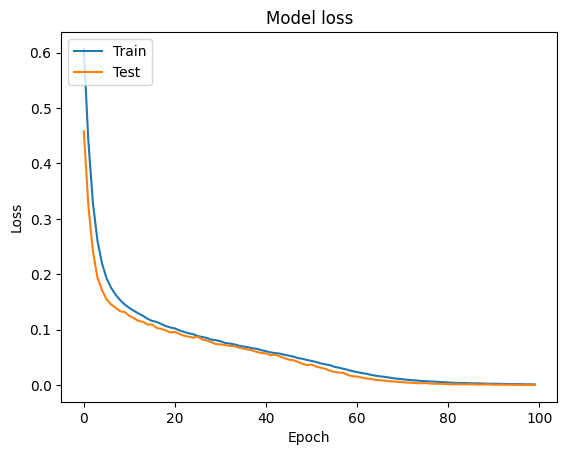

In [55]:
plot_loss(history)

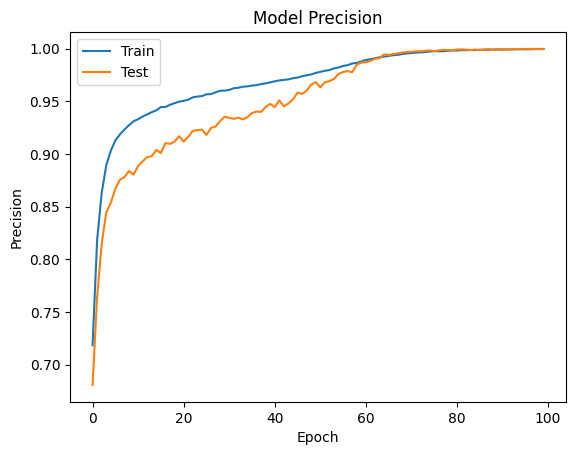

In [56]:
plot_precision(history, list(history.history)[1], list(history.history)[3])

# Saving Model

In [57]:
final_model.save('../models')

INFO:tensorflow:Assets written to: ../models\assets


INFO:tensorflow:Assets written to: ../models\assets
